In [5]:
import pandas as pd
import spacy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [ ]:
rawdata = pd.read_csv(r'C:\Users\52296881\Downloads\commonlitreadabilityprize\train.csv',index_col=0)
testdata = pd.read_csv(r'C:\Users\52296881\Downloads\commonlitreadabilityprize\test.csv',index_col=0)
df = rawdata.copy()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2834 entries, c12129c31 to 5b990ba77
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   url_legal       830 non-null    object 
 1   license         830 non-null    object 
 2   excerpt         2834 non-null   object 
 3   target          2834 non-null   float64
 4   standard_error  2834 non-null   float64
dtypes: float64(2), object(3)
memory usage: 132.8+ KB


In [7]:
df.describe()

,target,standard_error
count,2834.000000,2834.000000
mean,-0.959319,0.491435
std,1.033579,0.034818
min,-3.676268,0.000000
25%,-1.690320,0.468543
50%,-0.912190,0.484721
75%,-0.202540,0.506268
max,1.711390,0.649671


In [8]:
y = df.target
X_raw = df['excerpt']
print(X_raw.shape)
print(y.shape)
X_raw.head()

(2834,)
(2834,)


id
c12129c31    When the young people returned to the ballroom...
85aa80a4c    All through dinner time, Mrs. Fayre was somewh...
b69ac6792    As Roger had predicted, the snow departed as q...
dd1000b26    And outside before the palace a great garden w...
37c1b32fb    Once upon a time there were Three Bears who li...
Name: excerpt, dtype: object

In [21]:
import en_core_web_sm
def preprocess(X_raw):
    nlp = en_core_web_sm.load()
    docs = [nlp(exc) for exc in X_raw]

    # helper lists of lists to derive features below 
    doc_tok_lens = [[len(tok.text) for tok in doc] for doc in docs]
    doc_tok_lens_sq = [[tok_len**2 for tok_len in lengths] for lengths in doc_tok_lens]

    # n_toks
    doc_n_toks = [len(doc) for doc in docs]
    # n_stop_toks
    doc_n_stop_toks = [sum([tok.is_stop for tok in doc]) for doc in docs]
    # n_chars
    doc_n_chars = [len(doc.text) for doc in docs]
    # tok_len_mean
    doc_tok_len_means = [sum(lens)/len(lens) for lens in doc_tok_lens]
    # tok_len_var
    doc_tok_len_vars = [sum(lens2)/len(lens2) - (sum(lens)/len(lens))**2 for lens2, lens in zip(doc_tok_lens_sq, doc_tok_lens)]
    # n_punct
    doc_all_punct = [sum([tok.pos_ == 'PUNCT' for tok in doc]) for doc in docs]
    # n_special_punct
    doc_nonstd_punct = [sum([tok.lemma_ in ['-', ','] for tok in doc]) for doc in docs]

    # see https://universaldependencies.org/docs/u/pos/ for pos used by spaCy
    pos_all = ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X', 'SPACE']
    pos_dict = dict(zip(pos_all, list(range(len(pos_all)))))

    # pos_dist
    doc_pos_counts = [[0]*len(pos_all) for doc in docs]
    doc_pos_dist = [[0]*len(pos_all) for doc in docs]
    for i, doc in enumerate(docs):
        for tok in doc:
            if tok.pos_ not in pos_all:
                print("i = ", i, "   lemma = ", tok.lemma_)
            doc_pos_counts[i][pos_dict[tok.pos_]] += 1
        doc_pos_dist[i] = np.divide(doc_pos_counts[i], doc_n_toks[i])

    X = pd.DataFrame(doc_pos_dist, columns=['pos_' + pos.lower() for pos in pos_all])
    X['n_toks'] = doc_n_toks
    X['n_chars'] = doc_n_chars
    X['prop_stop_toks'] = np.divide(doc_n_stop_toks, doc_n_toks)
    X['tok_len_mean'] = doc_tok_len_means
    X['tok_len_var'] = doc_tok_len_vars
    X['prop_punct'] = np.divide(doc_all_punct, doc_n_chars)
    X['prop_nonstd_punct'] = np.divide(doc_nonstd_punct, doc_all_punct)

    return X


In [22]:
X = preprocess(X_raw)

In [23]:
X_train, X_val, y_train_actual, y_val_actual = train_test_split(X, y, test_size=0.2, random_state=5)

In [24]:
rf = RandomForestRegressor(n_estimators=100, random_state=1)
rf.fit(X_train, y_train_actual)

RandomForestRegressor(random_state=1)

In [25]:
y_train_predicted = rf.predict(X_train)
y_val_predicted = rf.predict(X_val)
train_mse = mean_squared_error(y_train_predicted, y_train_actual)
valid_mse = mean_squared_error(y_val_predicted, y_val_actual)
print(train_mse)
print(valid_mse)

0.08660564568600511
0.6144444128041545


Text(0, 0.5, 'predicted')

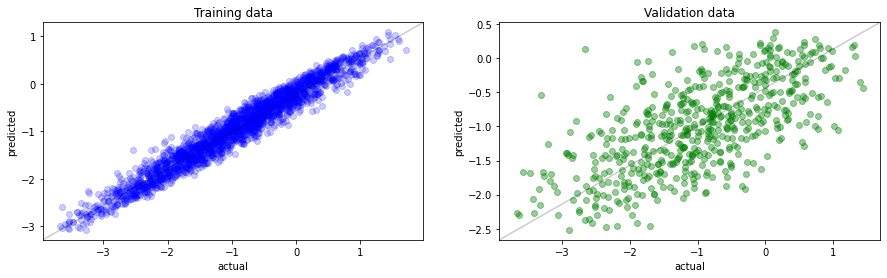

In [26]:
matplotlib.rc('figure', figsize=(15,4))
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot([0,1], [0,1], transform=ax1.transAxes, c='k', alpha=0.2)
ax1.scatter(y_train_actual, y_train_predicted, c='b', alpha=0.2)
ax1.set_title("Training data")
ax1.set_xlabel("actual")
ax1.set_ylabel("predicted")
ax2.plot([0,1], [0,1], transform=ax2.transAxes, c='k', alpha=0.2)
ax2.scatter(y_val_actual, y_val_predicted, c='g', alpha=0.4)
ax2.set_title("Validation data")
ax2.set_xlabel("actual")
ax2.set_ylabel("predicted")